In [1]:
# Import internal libraries
import glob, json

# Import external libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Analyze reliability, bandwidth, energy
data = []
refdir = "../lfsr"
for bpc in range(1, 3):
  refvec = np.loadtxt(f"{refdir}/lfsr_{bpc}bpc_data.txt", delimiter=',', dtype=np.int8)
  for alias in glob.glob(f"../settings/opt/{bpc}bpc*.json"):
    alias = alias.split("/")[-1][:-5]
    print(alias)
    for mode in ["cb", "lfsr"]:
      for att in [1, 2, 4, 8] + list(range(16, 256, 32)) + [255]:
        # Real max attempts
        att = (att & 31) << (att >> 5)

        # Load and compute data
        try:
          diag = json.load(open(f"data/diag/diag_{mode}_{alias}_{att}.json"))
          dt = np.loadtxt(f"data/dt/dt_{mode}_{alias}_{att}.csv", delimiter=',')
          ivdd = np.loadtxt(f"data/power/vdd_{mode}_power_{alias}_{att}.csv", delimiter=',')
          ivddio = np.loadtxt(f"data/power/vddio_{mode}_power_{alias}_{att}.csv", delimiter=',')
        except OSError:
          continue

        # Load data into confmat
        try:
            confmat = np.loadtxt(f"data/confmat/confmat_{mode}_{alias}_{att}.csv", delimiter=',')
        except OSError:
            try:
                postread = np.loadtxt(f"data/postread/postread_{mode}_{alias}_{att}.csv", delimiter=',', dtype=np.int8)
                confmat = np.zeros(shape=(2**bpc, 2**bpc))
                for i in range(65535):
                    for j in range(48):
                        if j in [2, 7, 16, 19, 23, 24, 29, 33, 38, 39, 43]: #[16, 19,24,29,38,43]:
                            continue
                        if mode == "cb":
                          confmat[(i + j) % (2**bpc)][postread[i][j]] += 1
                        elif mode == "lfsr":
                          confmat[refvec[i][j]][postread[i][j]] += 1
                        else:
                          raise Exception("Unknown mode")
                confmat = confmat.astype(int)
                np.savetxt(f"data/confmat/confmat_{mode}_{alias}_{att}.csv", confmat, fmt='%s', delimiter=',')
                print(confmat)
            except OSError:
                continue

        # Compute metrics
        power_tot = (ivdd * 0.9 + ivddio * 3.3).mean()
        dt2 = diag["cycles"] * 10e-9
        bw = confmat.sum() * bpc / dt2 # bits per second
        energy_per_bit = power_tot / bw
        edp = energy_per_bit / bw

        # Symbol error magnitudes
        mae = sum(abs(i - j) * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum()
        rmse = np.sqrt(sum((i - j)**2 * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum())

        # Function to get Gray code string
        getgray = lambda x : format(2**(2**bpc) + x^x//2, f"0{2**bpc-1}b")[1:]

        # Function to get Gray code error rate for each possible symbol confusion
        grayerr = np.array([[sum([int(ic != jc) for ic, jc in zip(getgray(i), getgray(j))]) for i in range(2**bpc)] for j in range(2**bpc)]) / bpc

        # BER and CER
        ber = (grayerr * confmat).sum() / confmat.sum()
        cer = 1 - confmat.trace() / confmat.sum()
        
        # Compose dataframe
        d = {"alias": f"{alias}_{mode}", "att": att, "bpc": bpc, "dt": dt, "dt2": dt2, "power_tot": power_tot, "energy_per_bit": energy_per_bit, "edp": edp, "bw": bw, "cer": cer, "ber": ber, "mae": mae, "rmse": rmse}
        d.update(diag)
        data.append(d)
data = pd.DataFrame(data)
data

1bpc_bwa_996
1bpc_bwa_0
1bpc_pba_571
2bpc_bwa_3028
2bpc_bwa_777
2bpc_bwa_751
2bpc_pba_420
2bpc_bwa_2818
2bpc_pba_422


,alias,att,bpc,dt,dt2,power_tot,energy_per_bit,edp,bw,cer,...,rmse,successes,failures,reads,sets,resets,cycles,read_bits,set_bits,reset_bits
0,1bpc_bwa_996_cb,1,1,0.056411027908325195,0.056361,0.005268,1.224567e-10,2.846333e-18,4.302261e+07,0.009164,...,0.095727,65536,131072,327680,65536,65536,5636095,3637248,1211171,1212031
1,1bpc_bwa_996_cb,2,1,0.0831000804901123,0.082917,0.004823,1.649340e-10,5.639964e-18,2.924380e+07,0.008122,...,0.090119,65536,32794,458752,86991,76875,8291656,7870644,1246258,1224481
2,1bpc_bwa_996_cb,4,1,0.0881345272064209,0.088066,0.004789,1.739384e-10,6.317261e-18,2.753383e+07,0.005925,...,0.076977,65536,8503,484748,83962,81609,8806602,8355367,1232999,1226662
3,1bpc_bwa_996_cb,8,1,0.09365582466125488,0.093205,0.004796,1.843336e-10,7.085453e-18,2.601579e+07,0.004779,...,0.069130,65536,5568,506160,91393,92655,9320476,8431830,1240148,1238345
4,1bpc_bwa_996_cb,16,1,0.09703302383422852,0.096918,0.004788,1.913795e-10,7.649381e-18,2.501896e+07,0.003810,...,0.061727,65536,3127,520478,86002,109923,9691830,8492076,1233287,1257773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,2bpc_bwa_2818_lfsr,128,2,1.1423723697662354,1.142073,0.004710,1.109191e-09,2.612131e-16,4.246306e+06,0.029649,...,0.268117,65536,12910,5184969,2359190,1937103,114207269,21170345,10086589,2758322
154,2bpc_bwa_2818_lfsr,256,2,1.517850637435913,1.517501,0.004822,1.508851e-09,4.721396e-16,3.195773e+06,0.029091,...,0.265987,65536,12096,6750937,2470484,3388822,151750139,22812892,10199920,4257629
155,2bpc_bwa_2818_lfsr,512,2,2.23634672164917,2.236194,0.004732,2.182187e-09,1.006228e-15,2.168680e+06,0.028490,...,0.263446,65536,11774,9746566,2667438,6186014,223619407,25917139,10391179,7154936
156,2bpc_bwa_2818_lfsr,1024,2,3.6495931148529053,3.649297,0.004835,3.638476e-09,2.737939e-15,1.328911e+06,0.027945,...,0.260834,65536,11530,15636026,3060302,11680587,364929659,31982618,10751369,12844195


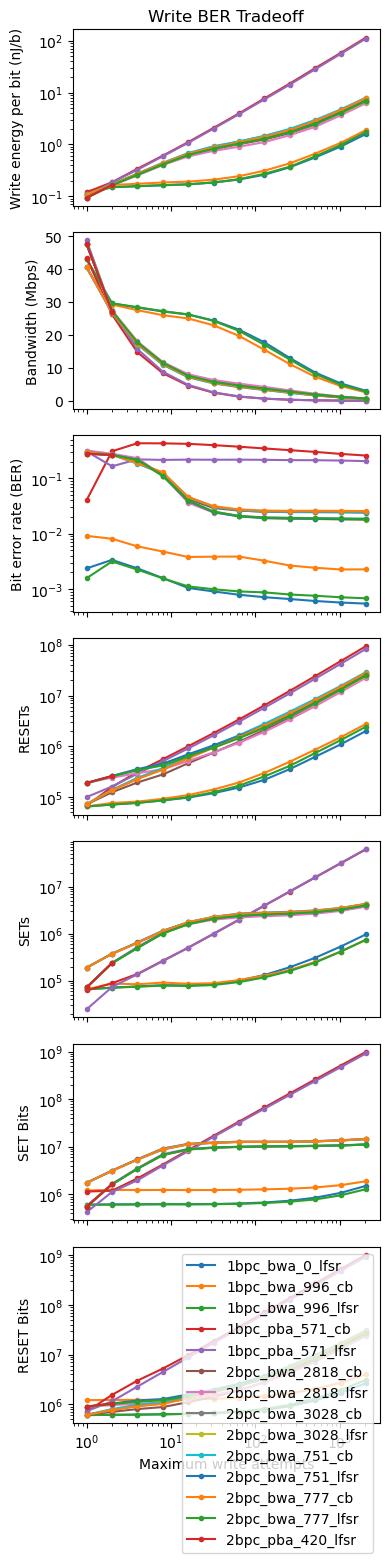

In [3]:
# Plot write BER tradeoff vs. attempts
fig, axs = plt.subplots(7, 1, figsize=(4,16), sharex=True)
for (bpc, alias), d in data.groupby(["bpc", "alias"]):
  plt.xlabel("Maximum write attempts")
  plt.xscale("log")
  axs[0].set_title(f"Write BER Tradeoff")
  axs[0].plot(d["att"], d["energy_per_bit"]*1e9, ".-", label=alias)
  axs[0].set_yscale("log")
  axs[0].set_ylabel("Write energy per bit (nJ/b)")
  axs[1].plot(d["att"], d["bw"]/1e6, ".-", label=alias)
  # axs[1].set_yscale("log")
  axs[1].set_ylabel("Bandwidth (Mbps)")
  # axs[2].plot(d["att"], d["edp"], ".-", label=alias)
  # axs[2].set_yscale("log")
  # axs[2].set_ylabel("EDP (J•s/b$^2$)")
  axs[2].plot(d["att"], d["ber"], ".-", label=alias)
  axs[2].set_yscale("log")
  axs[2].set_ylabel("Bit error rate (BER)")
  axs[3].plot(d["att"], d["resets"], ".-", label=alias)
  axs[3].set_yscale("log")
  axs[3].set_ylabel("RESETs")
  axs[4].plot(d["att"], d["sets"], ".-", label=alias)
  axs[4].set_yscale("log")
  axs[4].set_ylabel("SETs")
  axs[5].plot(d["att"], d["set_bits"], ".-", label=alias)
  axs[5].set_yscale("log")
  axs[5].set_ylabel("SET Bits")
  axs[6].plot(d["att"], d["reset_bits"], ".-", label=alias)
  axs[6].set_yscale("log")
  axs[6].set_ylabel("RESET Bits")
plt.legend()
plt.tight_layout()
# plt.savefig(f"../analysis/figs/{bpc}bpc_write_ber_tradeoff.pdf")
plt.subplots_adjust(hspace=0.15)
plt.show()